The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={"R (SM17)": "R (SM-17)"}, inplace=True)
df.rename(columns={"R (SM16)": "R (SM-16)"}, inplace=True)
df.head()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.641176,0.720,0.545,0.640,0.603,0.660
1,1,0.684,0.548,0.557143,0.464,0.340,0.478,0.444,0.582
2,1,0.698,0.667,0.900000,0.464,0.340,0.478,0.444,0.582
3,1,0.810,0.981,0.593333,0.730,0.503,0.654,0.622,0.740
4,1,0.796,0.916,0.595000,0.645,0.474,0.585,0.548,0.633


In [2]:
df.describe()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,418727.000000,418727.000000,418727.000000,418727.000000,418727.000000,418727.000000,418727.000000,418727.000000,418727.000000
mean,0.861633,0.846760,0.886217,0.868061,0.837918,0.838968,0.844751,0.843853,0.851702
std,0.345285,0.152085,0.145155,0.058900,0.161433,0.157917,0.140012,0.140858,0.102900
min,0.000000,0.000000,0.000000,0.064286,0.000000,0.004000,0.031000,0.031000,0.207000
25%,1.000000,0.803000,0.851000,0.867609,0.796000,0.790000,0.792000,0.793000,0.802000
50%,1.000000,0.902000,0.929000,0.884840,0.889000,0.891000,0.888000,0.887000,0.874000
75%,1.000000,0.947000,0.990000,0.899938,0.941000,0.946000,0.944000,0.943000,0.927000
max,1.000000,0.999000,1.000000,0.996970,1.000000,1.000000,1.000000,1.000000,1.000000


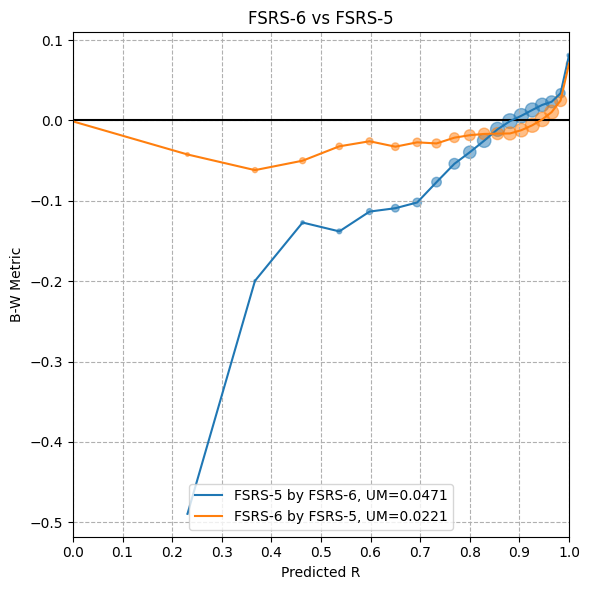

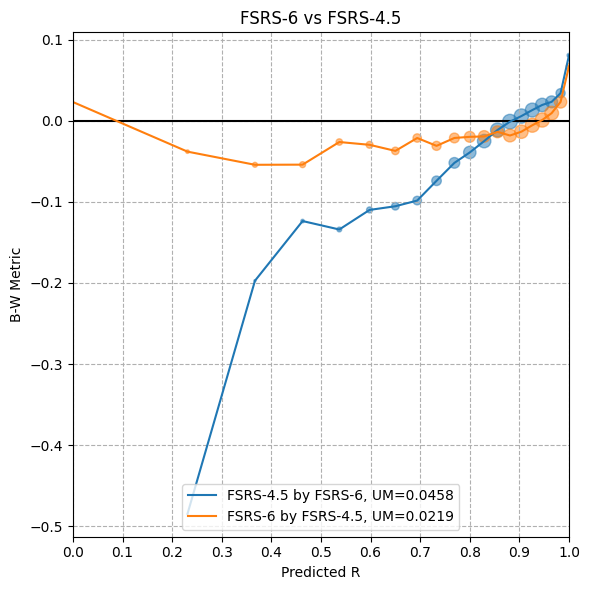

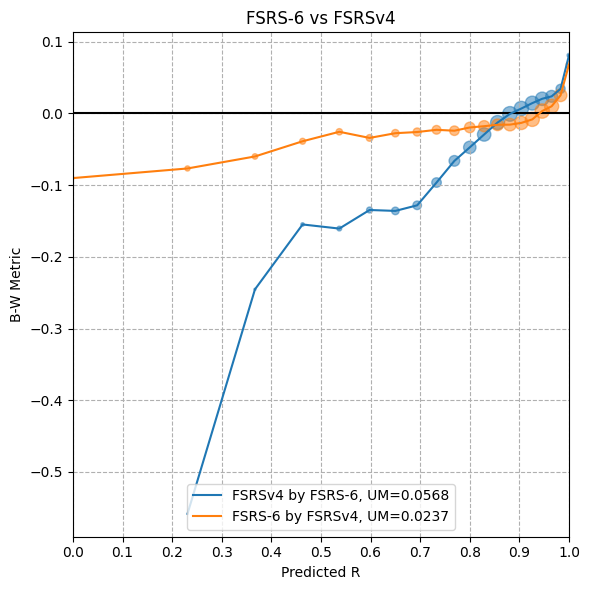

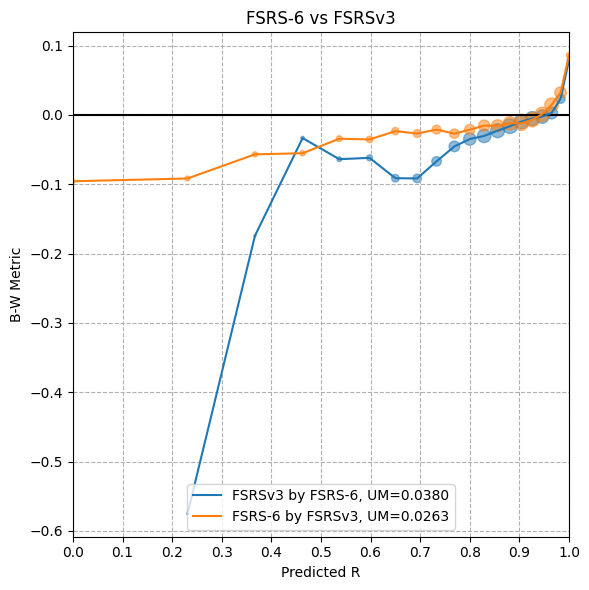

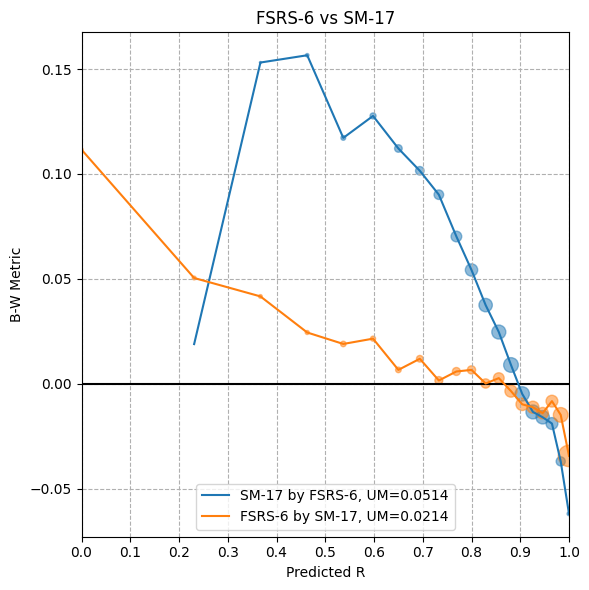

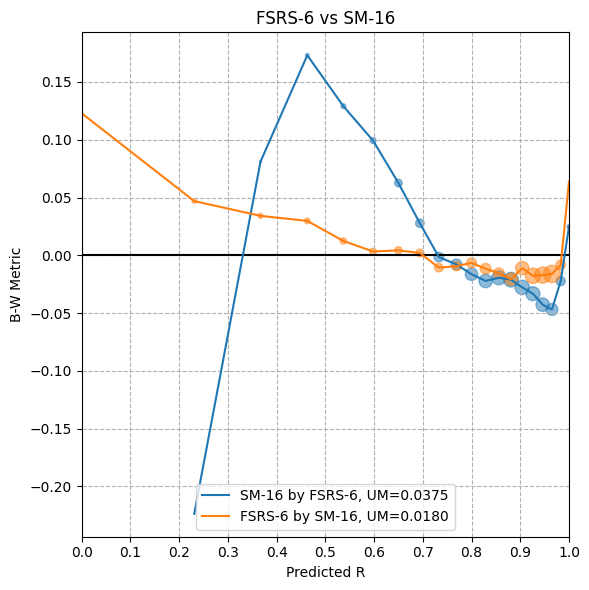

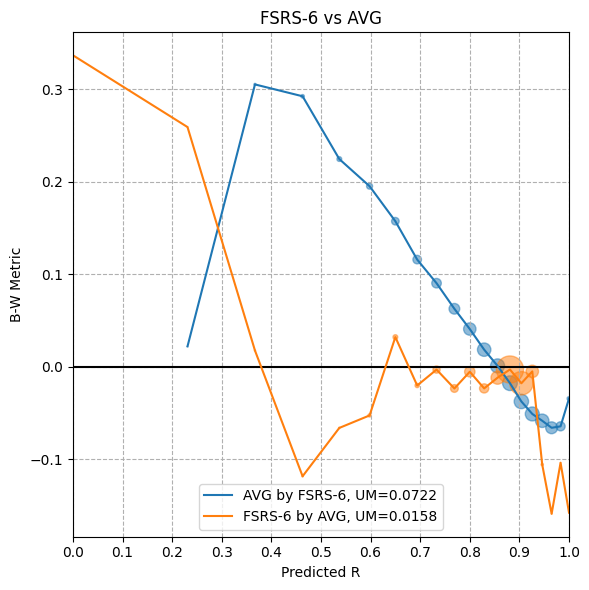

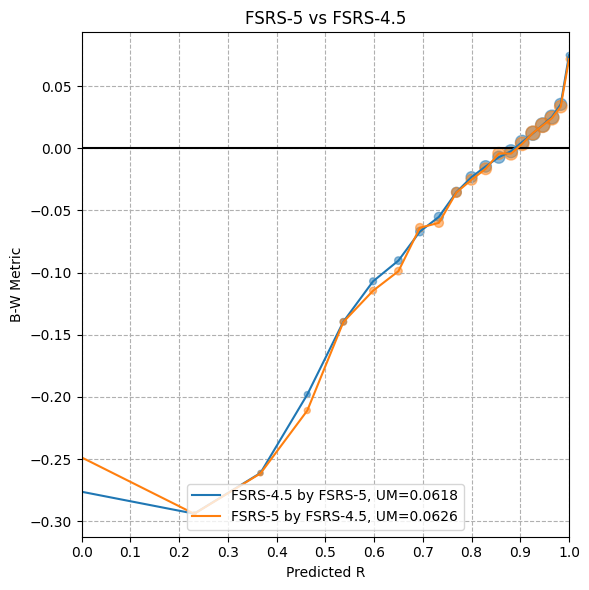

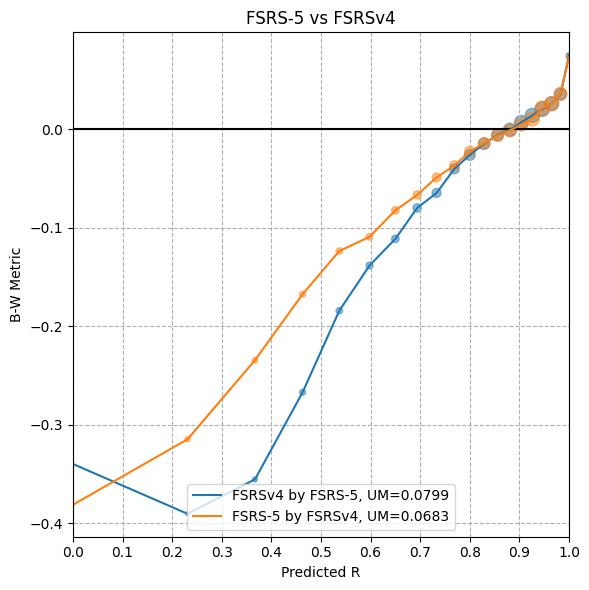

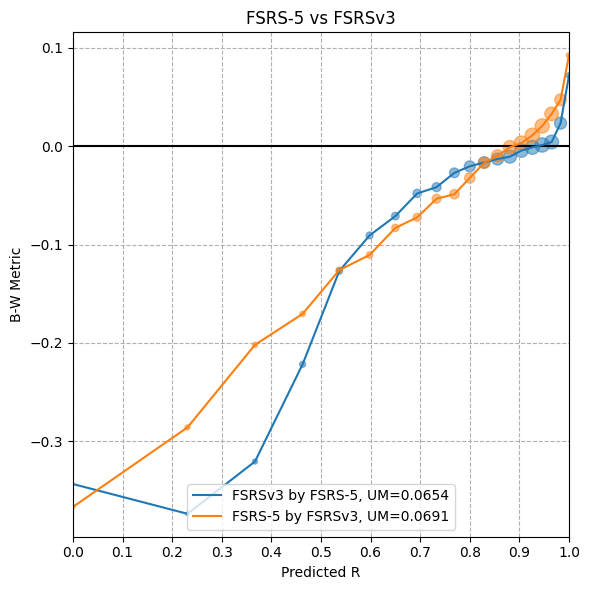

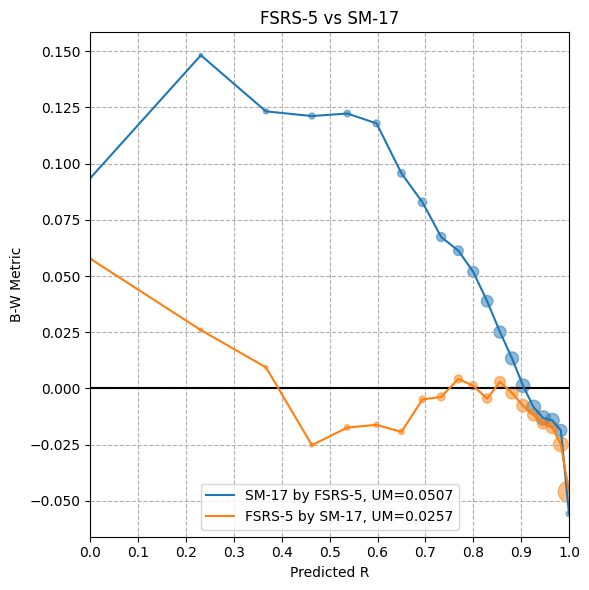

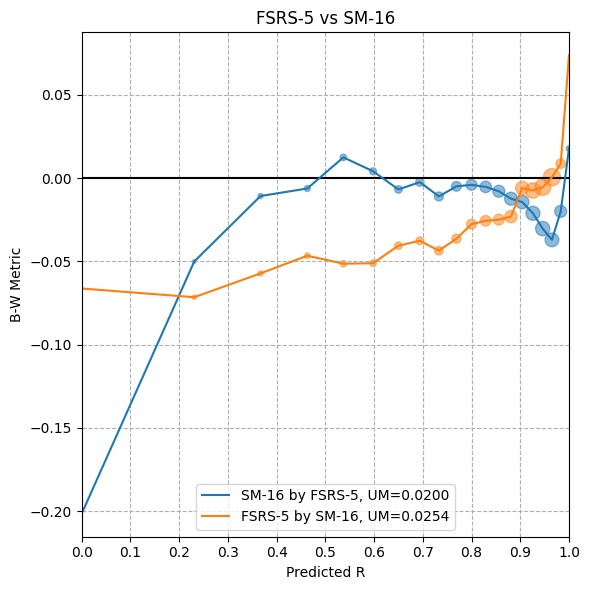

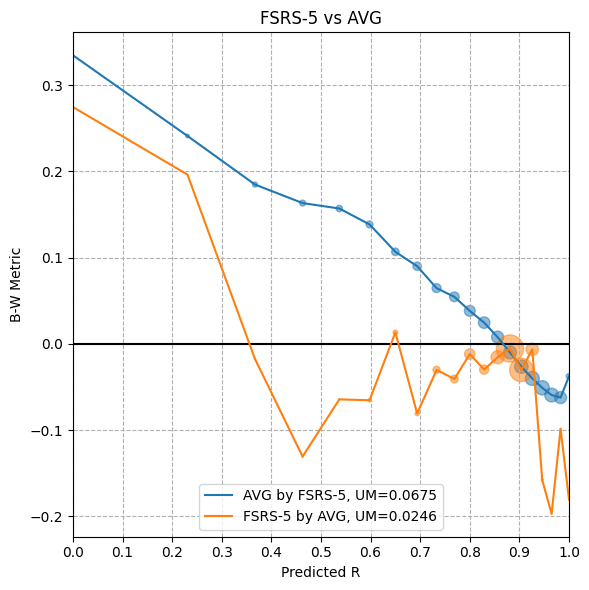

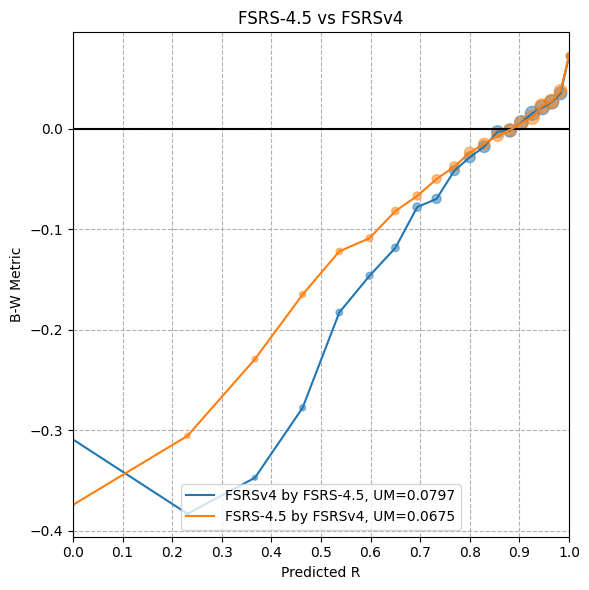

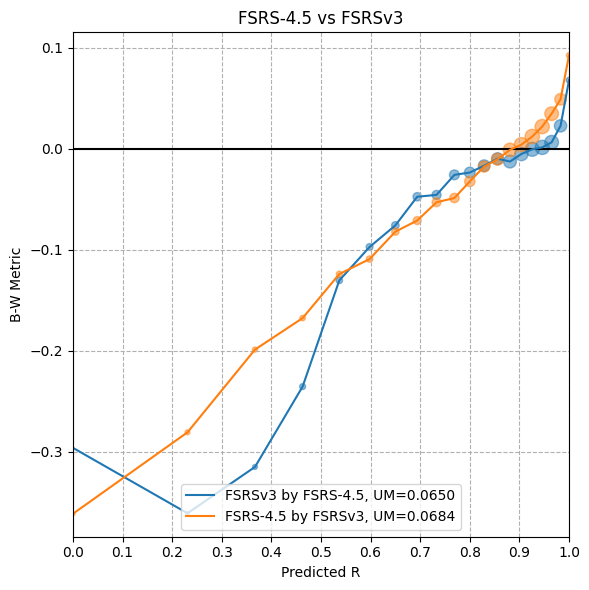

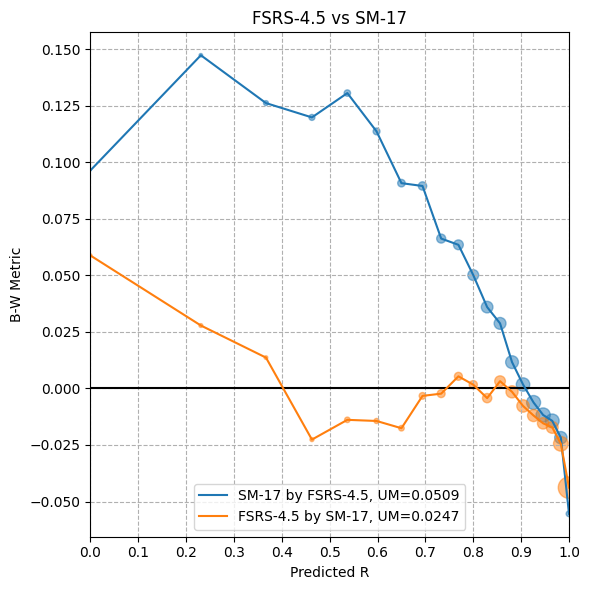

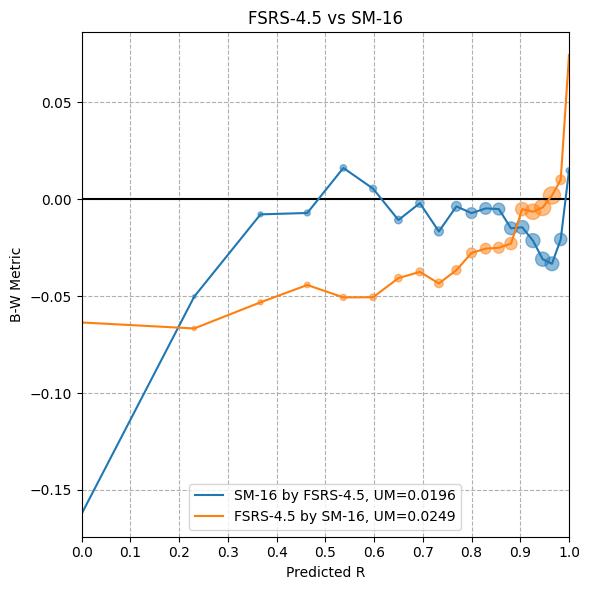

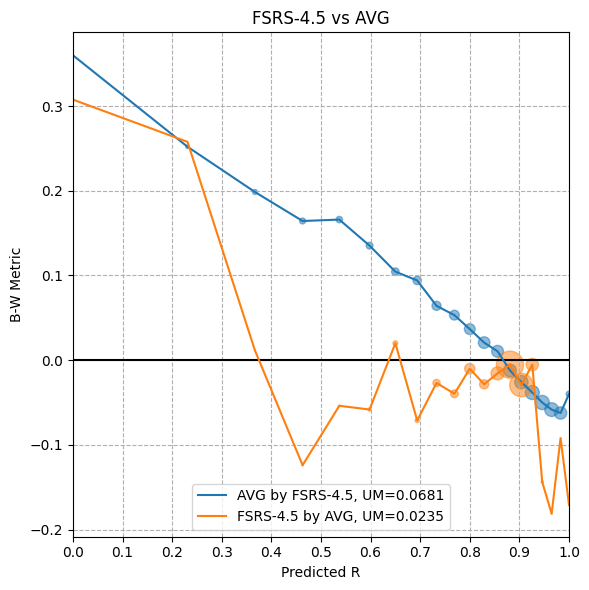

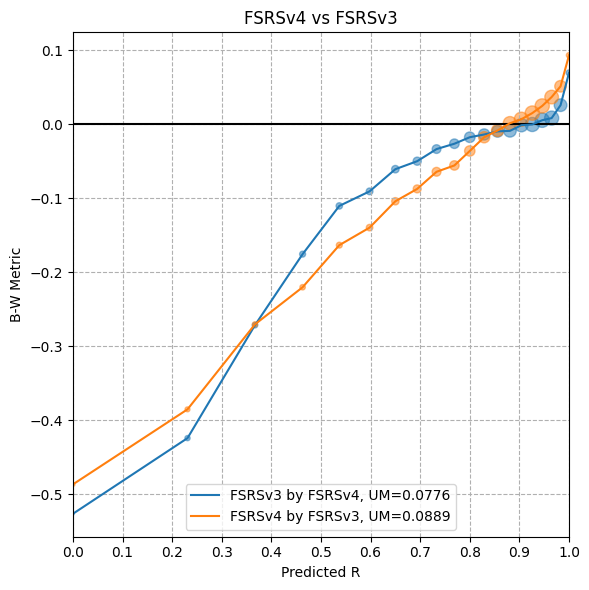

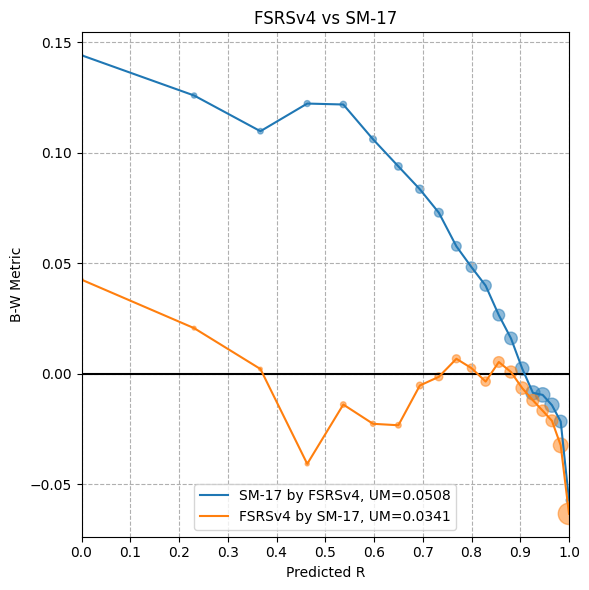

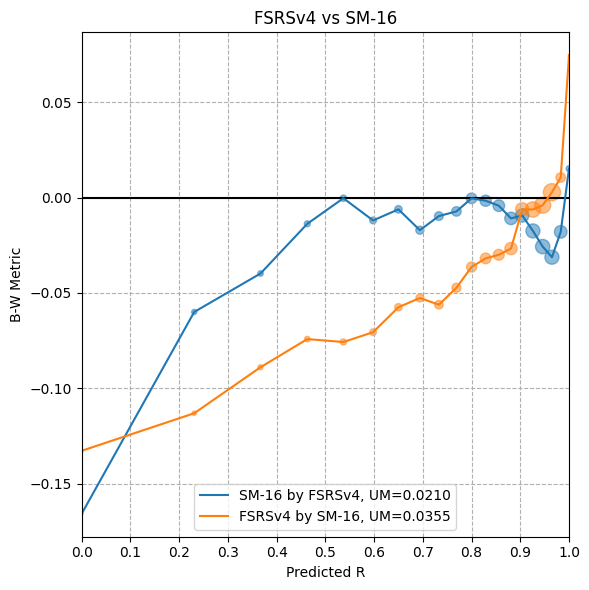

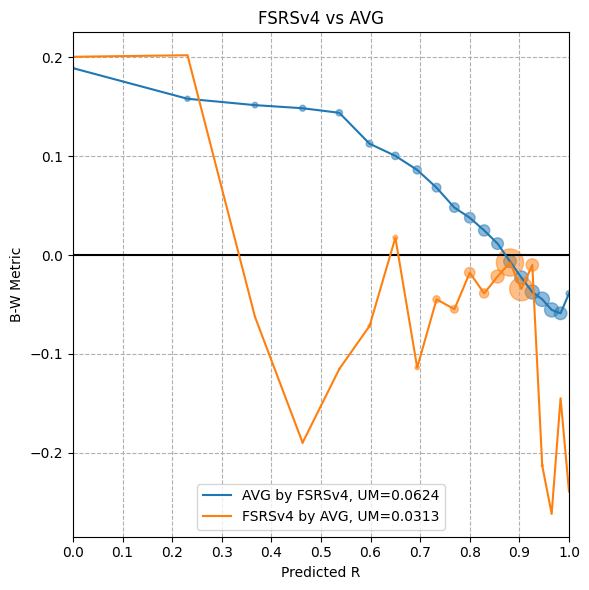

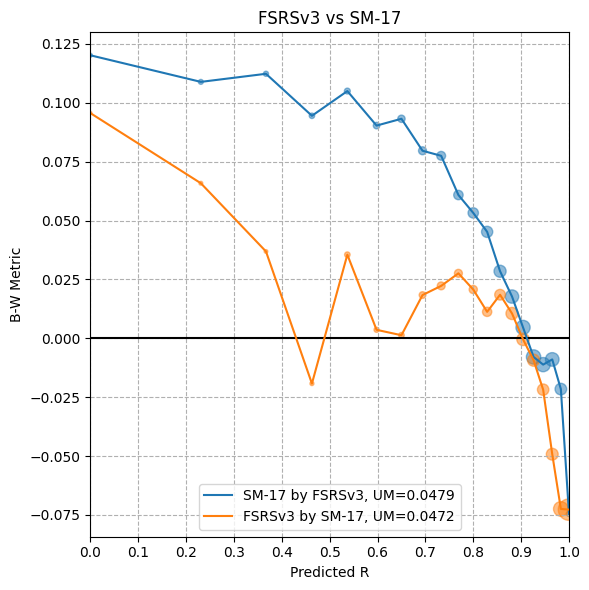

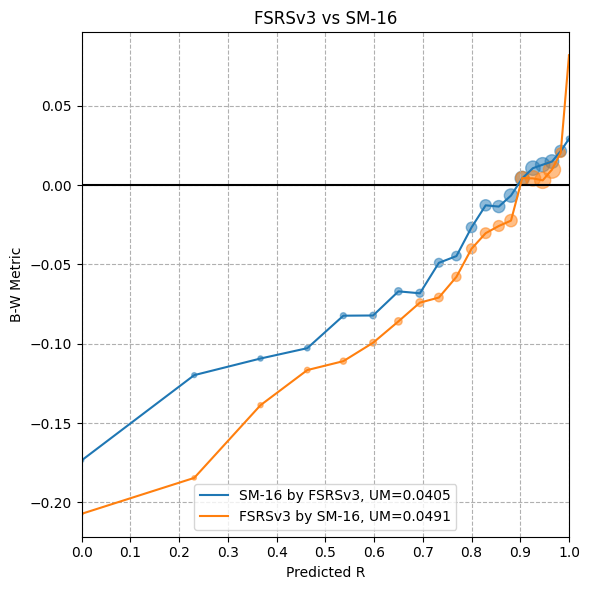

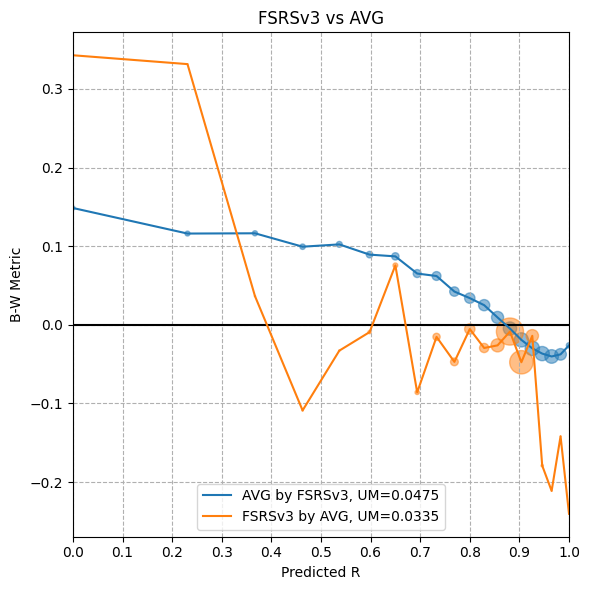

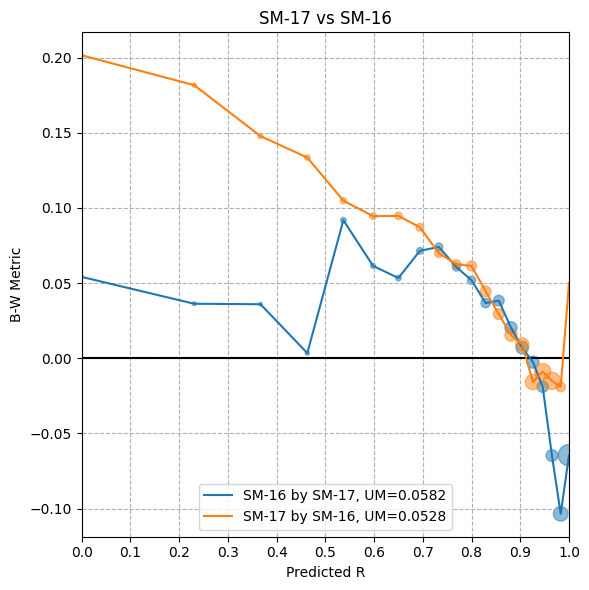

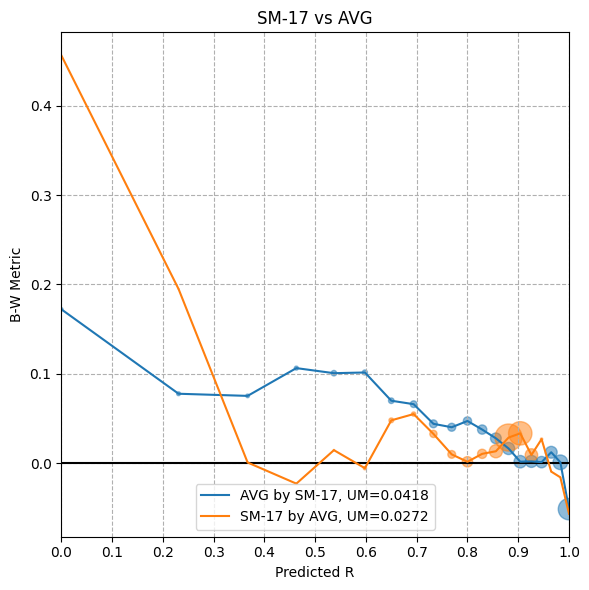

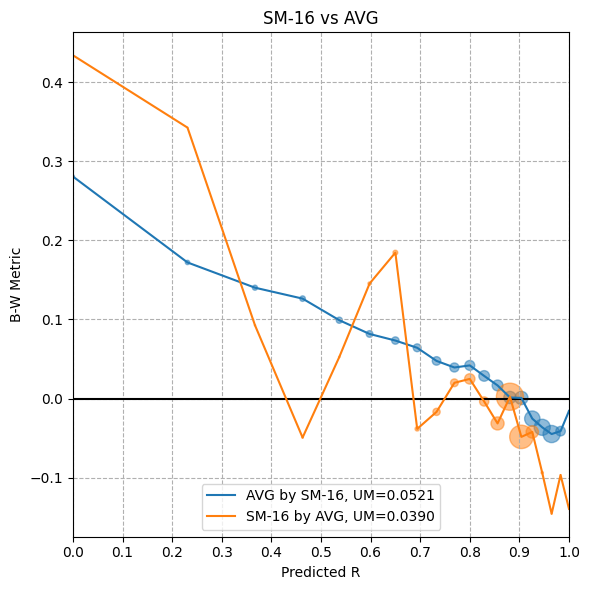

[{'FSRS-5_evaluated_by_FSRS-6': 0.0471, 'FSRS-6_evaluated_by_FSRS-5': 0.0221},
 {'FSRS-4.5_evaluated_by_FSRS-6': 0.0458,
  'FSRS-6_evaluated_by_FSRS-4.5': 0.0219},
 {'FSRSv4_evaluated_by_FSRS-6': 0.0568, 'FSRS-6_evaluated_by_FSRSv4': 0.0237},
 {'FSRSv3_evaluated_by_FSRS-6': 0.038, 'FSRS-6_evaluated_by_FSRSv3': 0.0263},
 {'SM-17_evaluated_by_FSRS-6': 0.0514, 'FSRS-6_evaluated_by_SM-17': 0.0214},
 {'SM-16_evaluated_by_FSRS-6': 0.0375, 'FSRS-6_evaluated_by_SM-16': 0.018},
 {'AVG_evaluated_by_FSRS-6': 0.0722, 'FSRS-6_evaluated_by_AVG': 0.0158},
 {'FSRS-4.5_evaluated_by_FSRS-5': 0.0618,
  'FSRS-5_evaluated_by_FSRS-4.5': 0.0626},
 {'FSRSv4_evaluated_by_FSRS-5': 0.0799, 'FSRS-5_evaluated_by_FSRSv4': 0.0683},
 {'FSRSv3_evaluated_by_FSRS-5': 0.0654, 'FSRS-5_evaluated_by_FSRSv3': 0.0691},
 {'SM-17_evaluated_by_FSRS-5': 0.0507, 'FSRS-5_evaluated_by_SM-17': 0.0257},
 {'SM-16_evaluated_by_FSRS-5': 0.02, 'FSRS-5_evaluated_by_SM-16': 0.0254},
 {'AVG_evaluated_by_FSRS-5': 0.0675, 'FSRS-5_evaluated_by_

In [3]:
from utils import cross_comparison
import itertools

results = []

all_algorithms = ["FSRS-6", "FSRS-5", "FSRS-4.5", "FSRSv4", "FSRSv3", "SM-17", "SM-16", "AVG"]

for player, referee in itertools.combinations(all_algorithms, 2):
    results.append(cross_comparison(df, player, referee))
results

In [4]:
import numpy as np

final_results = {}

for player in all_algorithms:
    universal_metrics = []
    for result in results:
        for key, value in result.items():
            if key.startswith(player):
                universal_metrics.append(value)
    final_results[player] = np.array(universal_metrics).mean().round(4)

# Sort by value (ascending, lower is better)
sorted_results = sorted(final_results.items(), key=lambda x: x[1])

# Display result in markdown table format, bold the best algorithm and its metric
print("| Algorithm | Universal Metric↓ |")
print("|-----------|------------------|")
for i, (algo, metric) in enumerate(sorted_results):
    if i == 0:
        print(f"| **{algo}** | **{metric:.4f}** |")
    else:
        print(f"| {algo} | {metric:.4f} |")

| Algorithm | Universal Metric↓ |
|-----------|------------------|
| **FSRS-6** | **0.0213** |
| SM-16 | 0.0337 |
| FSRS-4.5 | 0.0452 |
| FSRS-5 | 0.0461 |
| SM-17 | 0.0474 |
| FSRSv3 | 0.0537 |
| FSRSv4 | 0.0580 |
| AVG | 0.0588 |
